In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/chandniagarwal/Gan_Classifier.git

fatal: destination path 'Gan_Classifier' already exists and is not an empty directory.


In [3]:
import sys
sys.path.append('/content/Gan_Classifier/src')
import glob
import os
import numpy as np
import cv2
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import *
from keras import optimizers


from keras.models import Sequential
from keras.layers import Input, Dense, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

import time
import random
import seaborn as sns
from DatasetCreation import DatasetCreation
from Model import Model
from ElmModel import elm
from numba import cuda

In [4]:
tf.random.set_seed(
    42
)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
list_images=[]
labels=[]

In [5]:
# Testing Data Location
test_gt = "/content/drive/MyDrive/imageclassificationmodel/Datasets_FR/Testing/images_classification/gt"
test_gen = "/content/drive/MyDrive/imageclassificationmodel/Datasets_FR/Testing/images_classification/gen"
test_ec = "/content/drive/MyDrive/imageclassificationmodel/Datasets_FR/Testing/images_classification/ec"
test_vqvae = "/content/drive/MyDrive/imageclassificationmodel/Datasets_FR/Testing/images_classification/vqvae"
test_mask = "/content/drive/MyDrive/imageclassificationmodel/dataset/mask2000"
test_unmask = "/content/drive/MyDrive/imageclassificationmodel/dataset/gt2000"


In [6]:
# test_gt = '/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/e3'
# test_vqvae='/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/g3'

In [7]:
# Training Data Location
train_gt='/content/drive/MyDrive/imageclassificationmodel/Datasets_FR/training/gt'
train_recon='/content/drive/MyDrive/imageclassificationmodel/Datasets_FR/training/gen'

In [8]:
# training Data
image_loc_ground = glob.glob(train_gt+"/*.jpg")
labels = len(image_loc_ground) * ["ground"]
image_loc_recon = glob.glob(train_recon+"/*.jpg")

# so reconstructed and ground image dataset is of same size
random.shuffle(image_loc_recon)
image_loc_recon = image_loc_recon[:len(image_loc_ground)]

labels += len(image_loc_recon) * ["recon"]
image_loc = image_loc_ground + image_loc_recon
training_dataset = DatasetCreation(image_loc, labels, "one_hot")
# for 152 layer
training_dataset_152_layer = DatasetCreation(
    image_loc, labels, "one_hot", tf.keras.applications.resnet50.preprocess_input
)
print(training_dataset.images.shape)
print(training_dataset.labels.shape)

_________Loading Images__________


100%|██████████| 5476/5476 [04:34<00:00, 19.92it/s]


_________Loading Images__________


100%|██████████| 5476/5476 [00:19<00:00, 283.01it/s]


(5476, 224, 224, 3)
(5476, 2)


## load model

In [9]:
def load_model(model_function, trainable:bool):
  start = time.time()
  # load resnet model
  base_model = model_function(
      input_shape=(224,224,3),
      include_top=False,
      weights='imagenet'
  )

  for layer in base_model.layers:
      layer.trainable = trainable

  # Create your binary classification layers on top of the base model
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Add a global average pooling layer
  x = tf.keras.layers.Dense(1000, activation='relu')(x) # intermediate hidden layer
  x = tf.keras.layers.Dropout(0.2)(x)
  predictions = tf.keras.layers.Dense(2, activation='softmax')(x)  # Binary classification output layer

  # Combine the base model and your custom layers into a new model
  model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

  print('Running time: %.4f seconds' % (time.time()-start))
  return model

In [10]:
model_resnet_152_full = load_model(tf.keras.applications.ResNet152, True)
model_resnet_101_full = load_model(tf.keras.applications.ResNet101, True)
model_resnet_50_full = load_model(tf.keras.applications.ResNet50, True)

model_resnet_152_freeze = load_model(tf.keras.applications.ResNet152, False)
model_resnet_101_freeze = load_model(tf.keras.applications.ResNet101, False)
model_resnet_50_freeze = load_model(tf.keras.applications.ResNet50, False)

Running time: 6.2516 seconds
Running time: 3.3016 seconds
Running time: 1.7194 seconds
Running time: 5.2309 seconds
Running time: 3.4910 seconds
Running time: 1.7528 seconds


In [11]:
# best model calculate before the notebook crashed
model_resnet_152_full.load_weights("/content/drive/MyDrive/final_model/checkpoint/152_full/weights.08-0.00-1.00.hdf5")
model_resnet_101_full.load_weights("/content/drive/MyDrive/final_model/checkpoint/101_full/weights.10-0.00-1.00.hdf5")
model_resnet_50_full.load_weights("/content/drive/MyDrive/final_model/checkpoint/50_full/weights.06-0.00-1.00.hdf5")
model_resnet_152_freeze.load_weights("/content/drive/MyDrive/final_model/checkpoint/152_freeze/weights.02-0.24-0.95.hdf5")
model_resnet_101_freeze.load_weights("/content/drive/MyDrive/final_model/checkpoint/101_freeze/weights.02-0.71-0.48.hdf5")
model_resnet_50_freeze.load_weights("/content/drive/MyDrive/final_model/checkpoint/50_freeze/weights.02-0.66-0.62.hdf5")

In [12]:
model_softmax = {
    "152_full": model_resnet_152_full,
    "101_full": model_resnet_101_full,
    "50_full": model_resnet_50_full,
    "152_freeze": model_resnet_152_freeze,
    "101_freeze": model_resnet_101_freeze,
    "50_freeze": model_resnet_50_freeze,
}
model_data = {
    "152_full": training_dataset_152_layer,
    "101_full": training_dataset,
    "50_full": training_dataset,
    "152_freeze": training_dataset_152_layer,
    "101_freeze": training_dataset,
    "50_freeze": training_dataset,
}

## Resnet Training

In [14]:
for key in model_softmax.keys():
  print("_"*10, key, "_"*50)
  model_softmax[key] = Model(model_softmax[key], 0.001, f'/content/drive/MyDrive/final_model/checkpoint/{key}', "categorical_crossentropy")
  model_softmax[key].train(model_data[key].images, model_data[key].labels, batch_size=32, epoch=10)
  tf.keras.backend.clear_session()

__________ 152_full __________________________________________________
Epoch 1/10
154/154 [==============================] - 228s 785ms/step - loss: 0.3634 - accuracy: 0.8657 - val_loss: 141.5918 - val_accuracy: 0.0876 - lr: 0.0010
Epoch 2/10
154/154 [==============================] - 123s 800ms/step - loss: 0.0992 - accuracy: 0.9608 - val_loss: 2.3581 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 3/10
154/154 [==============================] - 123s 800ms/step - loss: 0.0591 - accuracy: 0.9801 - val_loss: 0.0416 - val_accuracy: 0.9836 - lr: 0.0010
Epoch 4/10
154/154 [==============================] - 122s 790ms/step - loss: 0.0385 - accuracy: 0.9872 - val_loss: 0.1093 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 5/10
154/154 [==============================] - 122s 789ms/step - loss: 0.0442 - accuracy: 0.9854 - val_loss: 0.1698 - val_accuracy: 0.9507 - lr: 0.0010
Epoch 6/10
154/154 [==============================] - 121s 787ms/step - loss: 0.0079 - accuracy: 0.9974 - val_loss: 0.1842 - val_acc

InternalError: ignored

In [13]:
for key in model_softmax.keys():
  model_softmax[key] = Model(model_softmax[key], 0.001, f'/content/drive/MyDrive/final_model/checkpoint/{key}', "categorical_crossentropy")

## Elm Training

In [14]:
for key in model_softmax.keys():
  for layer in model_softmax[key].model.layers:
      layer.trainable = False
  model_softmax[key].remove_layer(2)

In [29]:
def batch_predict(model, images, batch=32):
  array1 = []
  for idx in range(0, len(images), batch):
    array2 = model.predict(images[idx: min(len(images), idx+batch)], verbose=0)
    if len(array1)>0:
      array1 = np.concatenate((array1, array2), axis=0)
    else:
      array1 = array2
  return array1

In [30]:
model_elm = {}
for key in model_softmax.keys():
  print("_"*10, key, "_"*10)
  Xtrain = batch_predict(model_softmax[key].headless_model, model_data[key].images, 8)
  Ytrain = model_data[key].labels[...,0] == 0

  model_elm[key] = elm(hidden_units=16, activation_function='relu', random_type='normal', x=Xtrain, y=Ytrain, C=0.1, elm_type='clf')
  beta, train_accuracy, running_time = model_elm[key].fit('solution2')
  print("classifier train accuracy:", train_accuracy)
  print('classifier running time:', running_time)

__________ 152_full __________
classifier train accuracy: 0.9956172388604821
classifier running time: 0.022159814834594727
__________ 101_full __________
classifier train accuracy: 0.9983564645726808
classifier running time: 0.021697282791137695
__________ 50_full __________
classifier train accuracy: 0.9925127830533236
classifier running time: 0.020803451538085938
__________ 152_freeze __________
classifier train accuracy: 0.7247991234477721
classifier running time: 0.018244028091430664
__________ 101_freeze __________
classifier train accuracy: 0.5631848064280497
classifier running time: 0.015334367752075195
__________ 50_freeze __________
classifier train accuracy: 0.5505843681519357
classifier running time: 0.016055583953857422


## Svm Training

In [31]:
model_svm = {}
for key in model_softmax.keys():
  print("_"*10, key, "_"*10)
  #with tf.device('/CPU:0'):
  Xtrain = batch_predict(model_softmax[key].headless_model, model_data[key].images, 8)
  Ytrain = model_data[key].labels[...,0] == 0
  model_svm[key] = make_pipeline(SVC())
  model_svm[key].fit(Xtrain, Ytrain)
  print("Classifier train accuracy:", model_svm[key].score(Xtrain, Ytrain))

__________ 152_full __________
Classifier train accuracy: 0.9952520087655223
__________ 101_full __________
Classifier train accuracy: 0.9985390796201608
__________ 50_full __________
Classifier train accuracy: 0.9981738495252008
__________ 152_freeze __________
Classifier train accuracy: 0.8219503287070855
__________ 101_freeze __________
Classifier train accuracy: 0.6137691745799854
__________ 50_freeze __________
Classifier train accuracy: 0.6221694667640614


In [32]:
#dump training data
training_dataset = None
training_dataset_152_layer = None
model_data = None

## Load Test Data

In [33]:
# test Data
image_loc_ground = glob.glob(test_gt+"/*.jpg")
label_ground = len(image_loc_ground) * ["ground"]

image_loc_gen = glob.glob(test_gen+"/*.jpg")
label_gen = len(image_loc_gen) * ["recon"]

image_loc_ec = glob.glob(test_ec+"/*.jpg")
label_ec = len(image_loc_ec) * ["recon"]

image_loc_vqvae = glob.glob(test_vqvae+"/*.jpg")
label_vqvae = len(image_loc_vqvae) * ["recon"]

test_dataset = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary"
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary"
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary"
        ),
}

test_dataset_152_layer = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
}
model_data = {
    "152_full": test_dataset_152_layer,
    "101_full": test_dataset,
    "50_full": test_dataset,
    "152_freeze": test_dataset_152_layer,
    "101_freeze": test_dataset,
    "50_freeze": test_dataset,
}

_________Loading Images__________


100%|██████████| 2000/2000 [09:38<00:00,  3.46it/s]


_________Loading Images__________


100%|██████████| 2000/2000 [09:42<00:00,  3.44it/s]


_________Loading Images__________


100%|██████████| 2000/2000 [09:33<00:00,  3.49it/s]


_________Loading Images__________


100%|██████████| 2000/2000 [00:06<00:00, 313.46it/s]


_________Loading Images__________


100%|██████████| 2000/2000 [00:05<00:00, 334.54it/s]


_________Loading Images__________


100%|██████████| 2000/2000 [00:06<00:00, 310.16it/s]


## Testing Resnet

In [36]:
for model_name in model_softmax.keys():
  print("_"*10, model_name, "_"*10)

  for key in model_data[model_name].keys():
    y_result = batch_predict(model_softmax[model_name].model, model_data[model_name][key].images, 8)
    y_result = y_result[... ,0] < 0.5

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

__________ 152_full __________
__________gen__________
Accuracy 0.995
Precision: 1.000000
Recall: 0.990099
F1 score: 0.995025
__________ec__________
Accuracy 0.8575
Precision: 0.725000
Recall: 0.986395
F1 score: 0.835735
__________vqvae__________
Accuracy 0.59
Precision: 0.190000
Recall: 0.950000
F1 score: 0.316667
__________ 101_full __________
__________gen__________
Accuracy 0.997
Precision: 0.996000
Recall: 0.997996
F1 score: 0.996997
__________ec__________
Accuracy 0.8815
Precision: 0.765000
Recall: 0.997392
F1 score: 0.865874
__________vqvae__________
Accuracy 0.633
Precision: 0.268000
Recall: 0.992593
F1 score: 0.422047
__________ 50_full __________
__________gen__________
Accuracy 0.985
Precision: 0.998000
Recall: 0.972710
F1 score: 0.985192
__________ec__________
Accuracy 0.971
Precision: 0.970000
Recall: 0.971944
F1 score: 0.970971
__________vqvae__________
Accuracy 0.7215
Precision: 0.471000
Recall: 0.943888
F1 score: 0.628419
__________ 152_freeze __________
__________gen__

## Testing ELM

__________ 152_full __________
__________gen__________
Accuracy 0.9945
Precision: 0.998000
Recall: 0.991063
F1 score: 0.994519


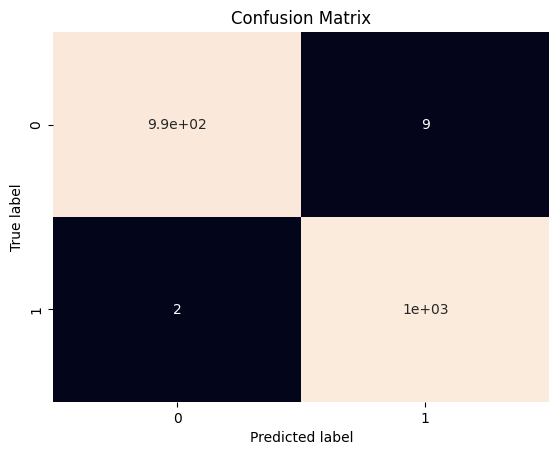

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1000
           1       0.99      1.00      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

__________ec__________
Accuracy 0.853
Precision: 0.715000
Recall: 0.987569
F1 score: 0.829466


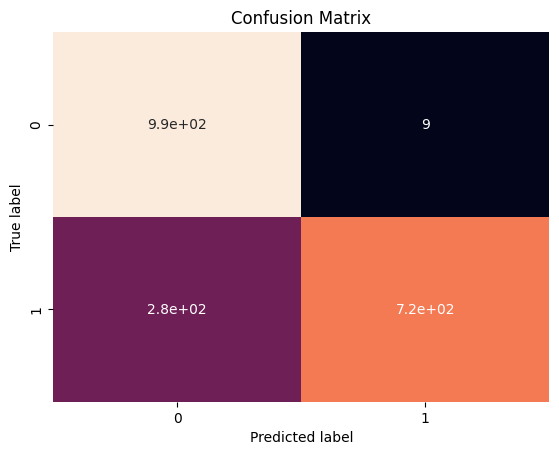

              precision    recall  f1-score   support

           0       0.78      0.99      0.87      1000
           1       0.99      0.71      0.83      1000

    accuracy                           0.85      2000
   macro avg       0.88      0.85      0.85      2000
weighted avg       0.88      0.85      0.85      2000

__________vqvae__________
Accuracy 0.601
Precision: 0.211000
Recall: 0.959091
F1 score: 0.345902


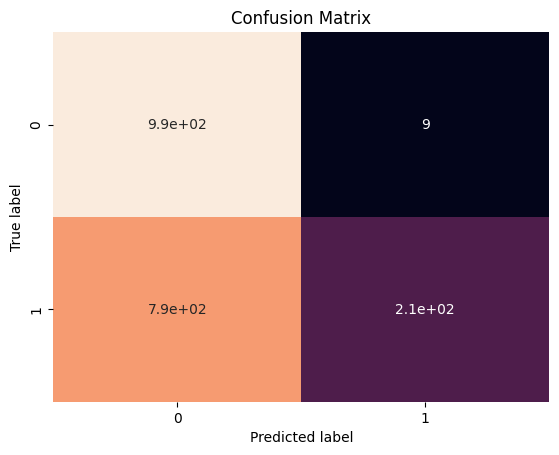

              precision    recall  f1-score   support

           0       0.56      0.99      0.71      1000
           1       0.96      0.21      0.35      1000

    accuracy                           0.60      2000
   macro avg       0.76      0.60      0.53      2000
weighted avg       0.76      0.60      0.53      2000

__________ 101_full __________
__________gen__________
Accuracy 0.9975
Precision: 0.997000
Recall: 0.997998
F1 score: 0.997499


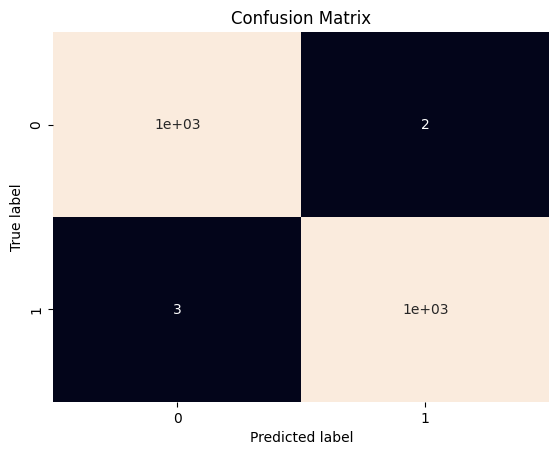

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

__________ec__________
Accuracy 0.88
Precision: 0.762000
Recall: 0.997382
F1 score: 0.863946


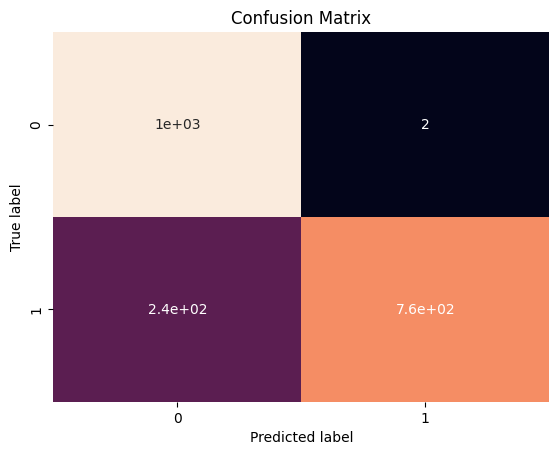

              precision    recall  f1-score   support

           0       0.81      1.00      0.89      1000
           1       1.00      0.76      0.86      1000

    accuracy                           0.88      2000
   macro avg       0.90      0.88      0.88      2000
weighted avg       0.90      0.88      0.88      2000

__________vqvae__________
Accuracy 0.627
Precision: 0.256000
Recall: 0.992248
F1 score: 0.406995


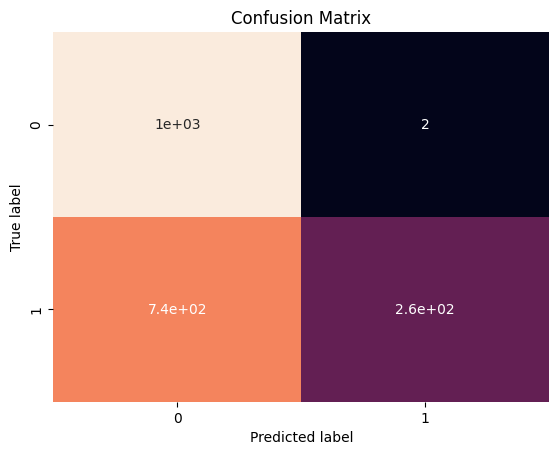

              precision    recall  f1-score   support

           0       0.57      1.00      0.73      1000
           1       0.99      0.26      0.41      1000

    accuracy                           0.63      2000
   macro avg       0.78      0.63      0.57      2000
weighted avg       0.78      0.63      0.57      2000

__________ 50_full __________
__________gen__________
Accuracy 0.989
Precision: 0.999000
Recall: 0.979412
F1 score: 0.989109


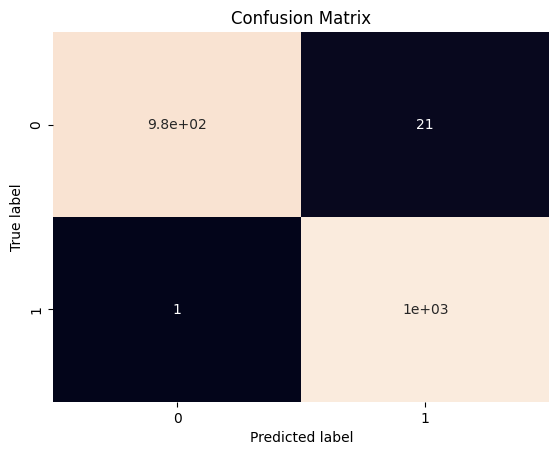

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1000
           1       0.98      1.00      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

__________ec__________
Accuracy 0.967
Precision: 0.955000
Recall: 0.978484
F1 score: 0.966599


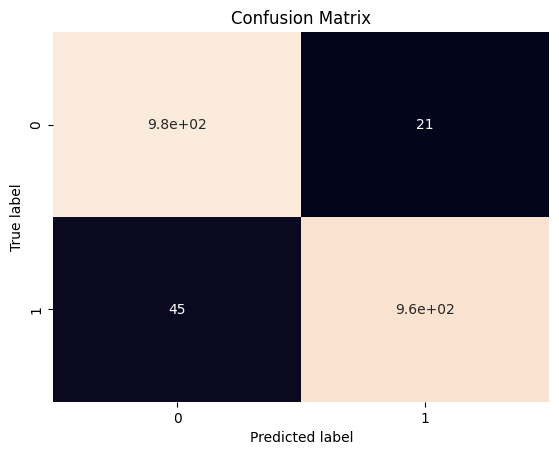

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1000
           1       0.98      0.95      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

__________vqvae__________
Accuracy 0.689
Precision: 0.399000
Recall: 0.950000
F1 score: 0.561972


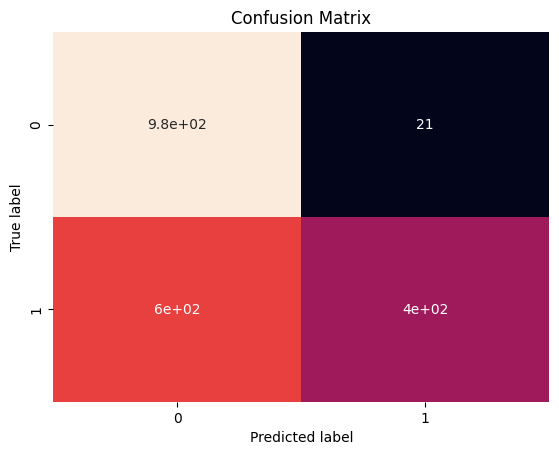

              precision    recall  f1-score   support

           0       0.62      0.98      0.76      1000
           1       0.95      0.40      0.56      1000

    accuracy                           0.69      2000
   macro avg       0.78      0.69      0.66      2000
weighted avg       0.78      0.69      0.66      2000

__________ 152_freeze __________
__________gen__________
Accuracy 0.713
Precision: 0.709000
Recall: 0.714718
F1 score: 0.711847


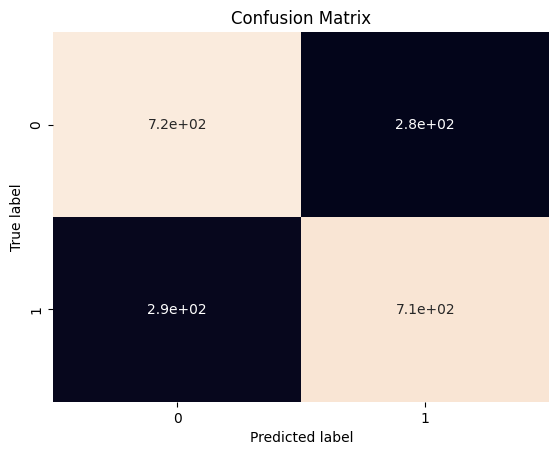

              precision    recall  f1-score   support

           0       0.71      0.72      0.71      1000
           1       0.71      0.71      0.71      1000

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.71      0.71      0.71      2000

__________ec__________
Accuracy 0.836
Precision: 0.955000
Recall: 0.771405
F1 score: 0.853441


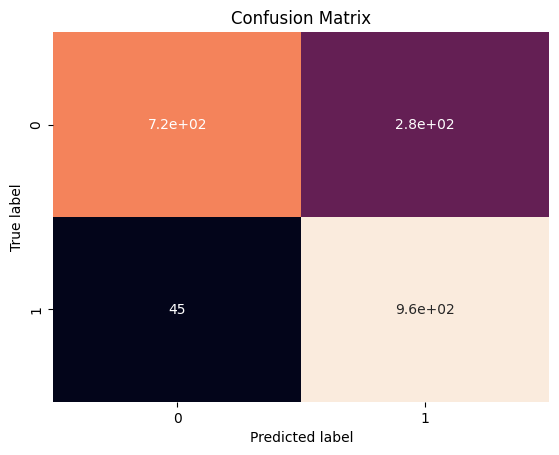

              precision    recall  f1-score   support

           0       0.94      0.72      0.81      1000
           1       0.77      0.95      0.85      1000

    accuracy                           0.84      2000
   macro avg       0.86      0.84      0.83      2000
weighted avg       0.86      0.84      0.83      2000

__________vqvae__________
Accuracy 0.6655
Precision: 0.614000
Recall: 0.684504
F1 score: 0.647338


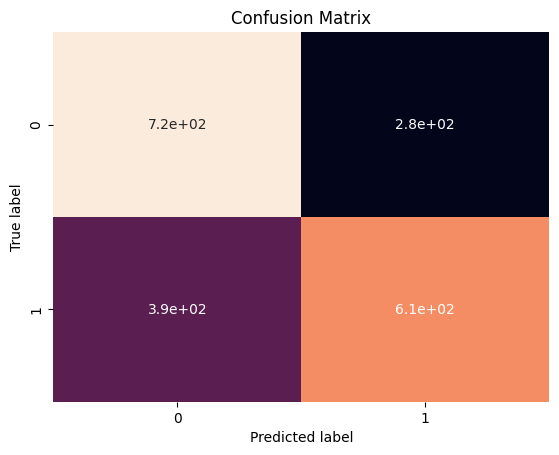

              precision    recall  f1-score   support

           0       0.65      0.72      0.68      1000
           1       0.68      0.61      0.65      1000

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.66      2000
weighted avg       0.67      0.67      0.66      2000

__________ 101_freeze __________
__________gen__________
Accuracy 0.541
Precision: 0.542000
Recall: 0.540918
F1 score: 0.541459


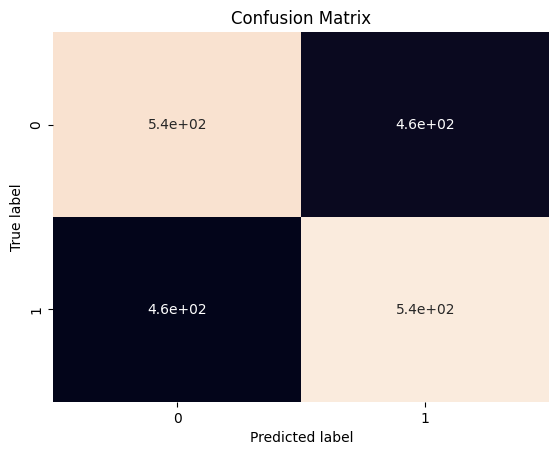

              precision    recall  f1-score   support

           0       0.54      0.54      0.54      1000
           1       0.54      0.54      0.54      1000

    accuracy                           0.54      2000
   macro avg       0.54      0.54      0.54      2000
weighted avg       0.54      0.54      0.54      2000

__________ec__________
Accuracy 0.5875
Precision: 0.635000
Recall: 0.579909
F1 score: 0.606205


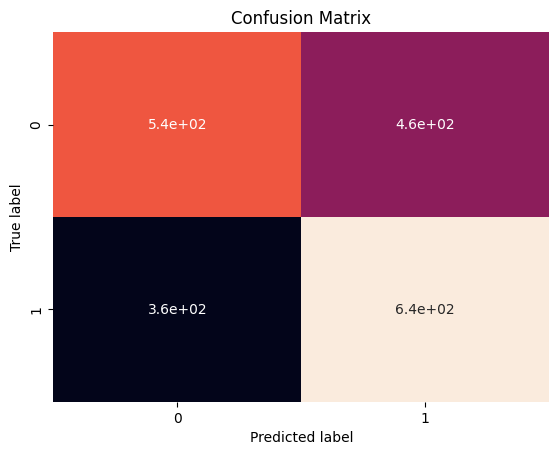

              precision    recall  f1-score   support

           0       0.60      0.54      0.57      1000
           1       0.58      0.64      0.61      1000

    accuracy                           0.59      2000
   macro avg       0.59      0.59      0.59      2000
weighted avg       0.59      0.59      0.59      2000

__________vqvae__________
Accuracy 0.5015
Precision: 0.463000
Recall: 0.501625
F1 score: 0.481539


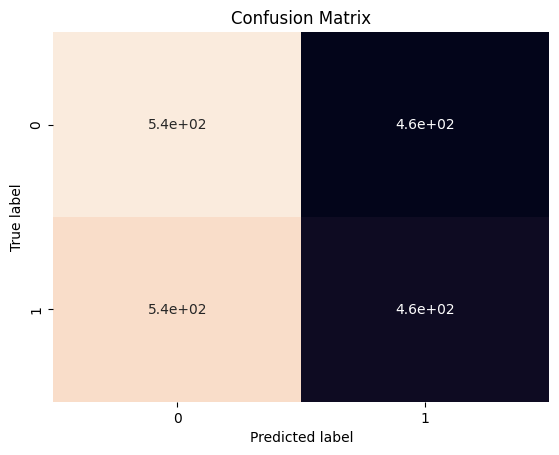

              precision    recall  f1-score   support

           0       0.50      0.54      0.52      1000
           1       0.50      0.46      0.48      1000

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000

__________ 50_freeze __________
__________gen__________
Accuracy 0.534
Precision: 0.461000
Recall: 0.539813
F1 score: 0.497303


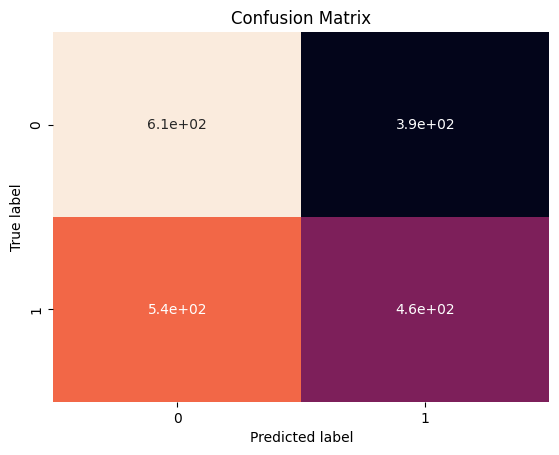

              precision    recall  f1-score   support

           0       0.53      0.61      0.57      1000
           1       0.54      0.46      0.50      1000

    accuracy                           0.53      2000
   macro avg       0.53      0.53      0.53      2000
weighted avg       0.53      0.53      0.53      2000

__________ec__________
Accuracy 0.552
Precision: 0.497000
Recall: 0.558427
F1 score: 0.525926


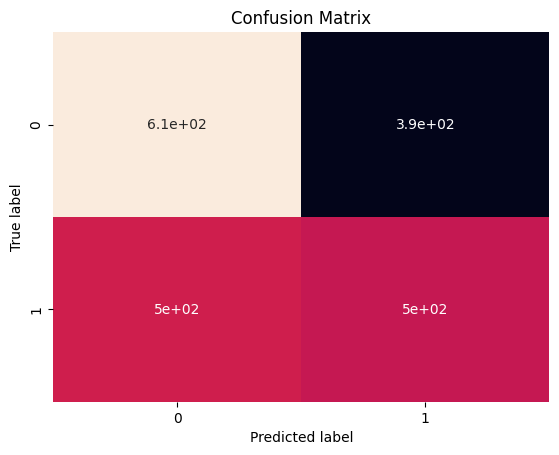

              precision    recall  f1-score   support

           0       0.55      0.61      0.58      1000
           1       0.56      0.50      0.53      1000

    accuracy                           0.55      2000
   macro avg       0.55      0.55      0.55      2000
weighted avg       0.55      0.55      0.55      2000

__________vqvae__________
Accuracy 0.4885
Precision: 0.370000
Recall: 0.484928
F1 score: 0.419739


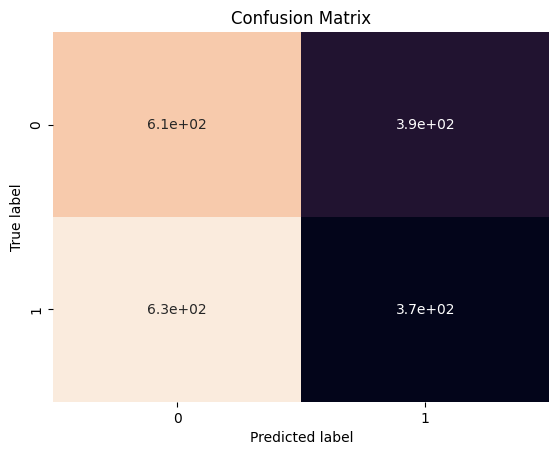

              precision    recall  f1-score   support

           0       0.49      0.61      0.54      1000
           1       0.48      0.37      0.42      1000

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.48      2000
weighted avg       0.49      0.49      0.48      2000



In [37]:
for model_name in model_softmax.keys():
  print("_"*10, model_name, "_"*10)

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 8)
    y_result = model_elm[model_name].predict(Xtest)

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

    cm8 = confusion_matrix(labels, y_result)
    sns.heatmap(cm8, annot=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(labels, y_result))

## Testing SVM

__________ 152_full __________
__________gen__________
Accuracy 0.9955
Precision: 0.995000
Recall: 0.995996
F1 score: 0.995498


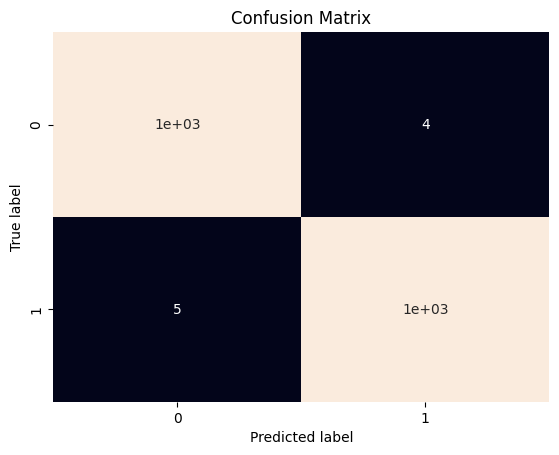

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      0.99      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

__________ec__________
Accuracy 0.822
Precision: 0.648000
Recall: 0.993865
F1 score: 0.784504


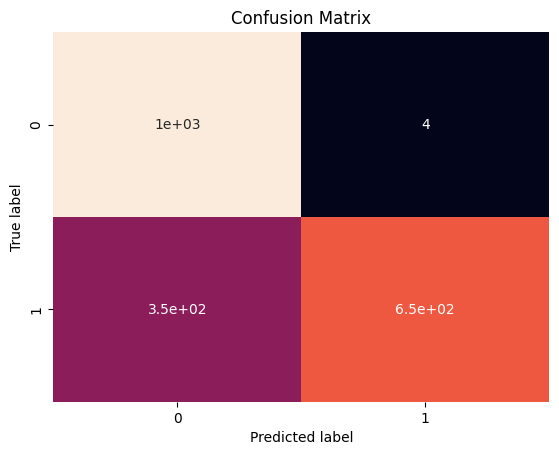

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1000
           1       0.99      0.65      0.78      1000

    accuracy                           0.82      2000
   macro avg       0.87      0.82      0.82      2000
weighted avg       0.87      0.82      0.82      2000

__________vqvae__________
Accuracy 0.561
Precision: 0.126000
Recall: 0.969231
F1 score: 0.223009


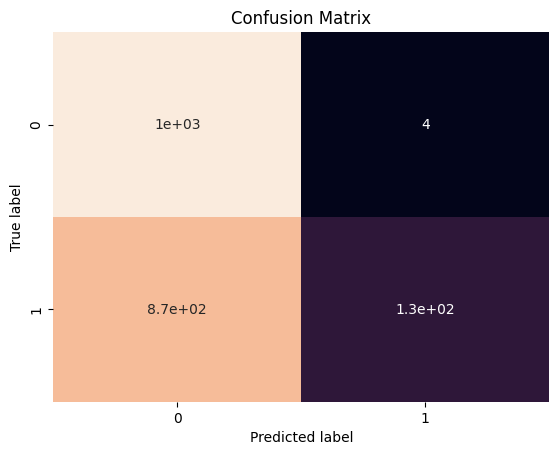

              precision    recall  f1-score   support

           0       0.53      1.00      0.69      1000
           1       0.97      0.13      0.22      1000

    accuracy                           0.56      2000
   macro avg       0.75      0.56      0.46      2000
weighted avg       0.75      0.56      0.46      2000

__________ 101_full __________
__________gen__________
Accuracy 0.9975
Precision: 0.995000
Recall: 1.000000
F1 score: 0.997494


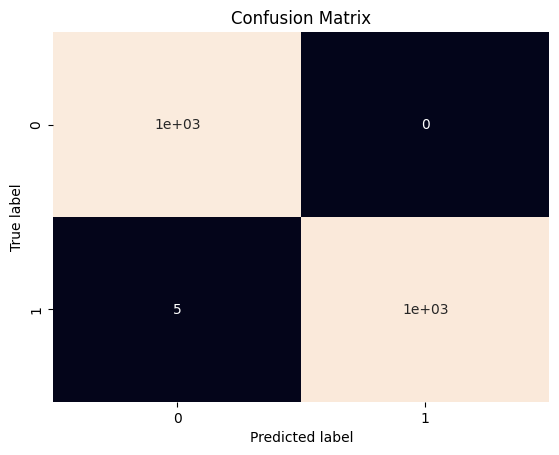

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      0.99      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

__________ec__________
Accuracy 0.863
Precision: 0.726000
Recall: 1.000000
F1 score: 0.841251


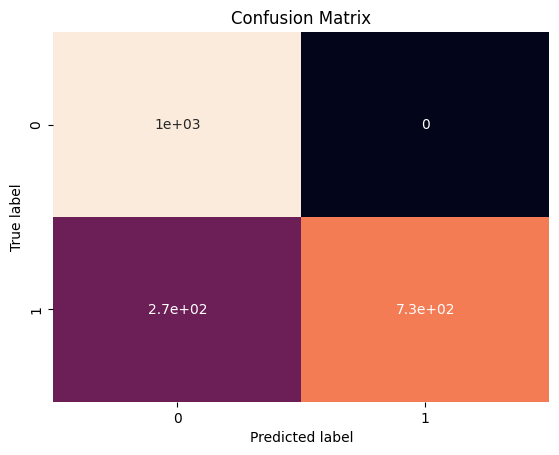

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1000
           1       1.00      0.73      0.84      1000

    accuracy                           0.86      2000
   macro avg       0.89      0.86      0.86      2000
weighted avg       0.89      0.86      0.86      2000

__________vqvae__________
Accuracy 0.607
Precision: 0.214000
Recall: 1.000000
F1 score: 0.352554


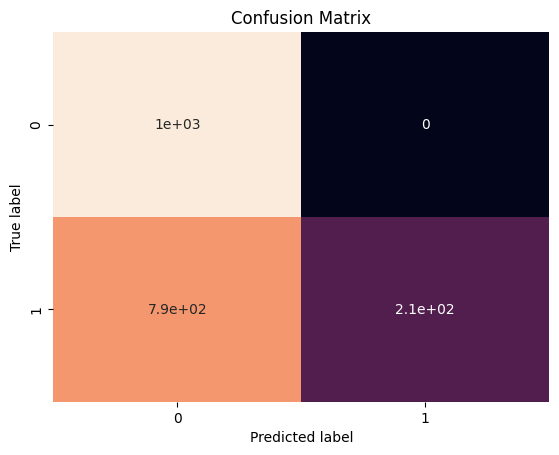

              precision    recall  f1-score   support

           0       0.56      1.00      0.72      1000
           1       1.00      0.21      0.35      1000

    accuracy                           0.61      2000
   macro avg       0.78      0.61      0.54      2000
weighted avg       0.78      0.61      0.54      2000

__________ 50_full __________
__________gen__________
Accuracy 0.995
Precision: 0.992000
Recall: 0.997988
F1 score: 0.994985


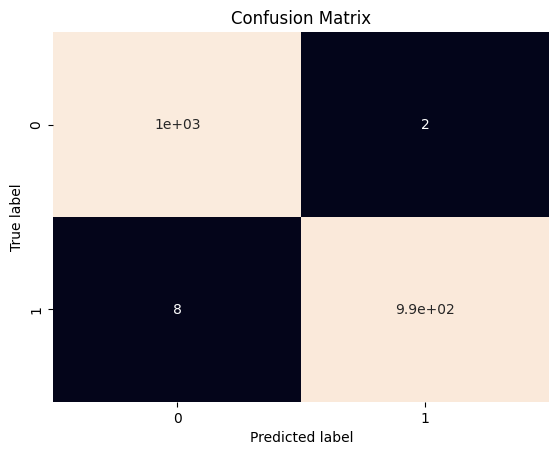

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1000
           1       1.00      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      0.99      0.99      2000

__________ec__________
Accuracy 0.928
Precision: 0.858000
Recall: 0.997674
F1 score: 0.922581


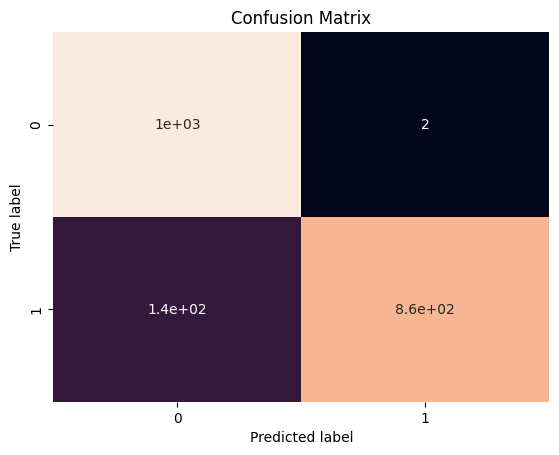

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1000
           1       1.00      0.86      0.92      1000

    accuracy                           0.93      2000
   macro avg       0.94      0.93      0.93      2000
weighted avg       0.94      0.93      0.93      2000

__________vqvae__________
Accuracy 0.597
Precision: 0.196000
Recall: 0.989899
F1 score: 0.327212


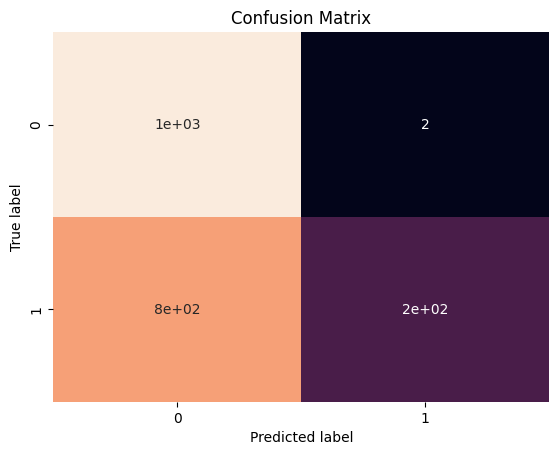

              precision    recall  f1-score   support

           0       0.55      1.00      0.71      1000
           1       0.99      0.20      0.33      1000

    accuracy                           0.60      2000
   macro avg       0.77      0.60      0.52      2000
weighted avg       0.77      0.60      0.52      2000

__________ 152_freeze __________
__________gen__________
Accuracy 0.7925
Precision: 0.745000
Recall: 0.823204
F1 score: 0.782152


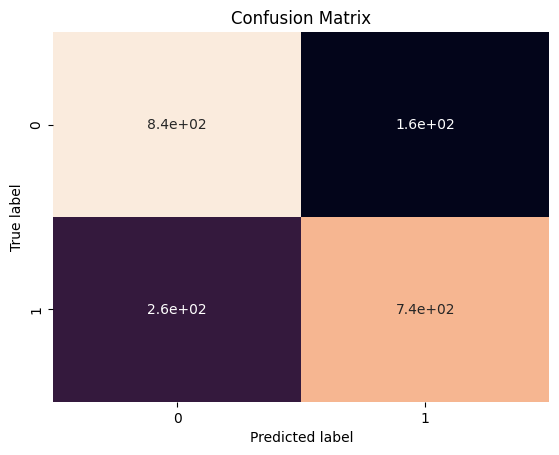

              precision    recall  f1-score   support

           0       0.77      0.84      0.80      1000
           1       0.82      0.74      0.78      1000

    accuracy                           0.79      2000
   macro avg       0.80      0.79      0.79      2000
weighted avg       0.80      0.79      0.79      2000

__________ec__________
Accuracy 0.913
Precision: 0.986000
Recall: 0.860384
F1 score: 0.918919


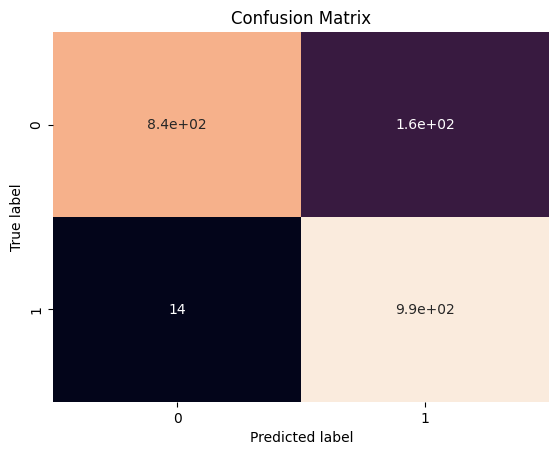

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      1000
           1       0.86      0.99      0.92      1000

    accuracy                           0.91      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.92      0.91      0.91      2000

__________vqvae__________
Accuracy 0.727
Precision: 0.614000
Recall: 0.793282
F1 score: 0.692221


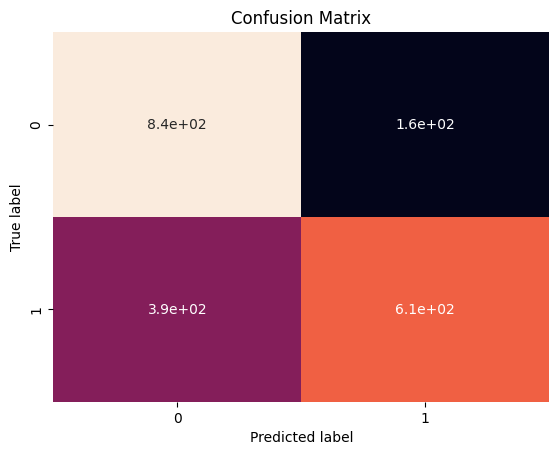

              precision    recall  f1-score   support

           0       0.69      0.84      0.75      1000
           1       0.79      0.61      0.69      1000

    accuracy                           0.73      2000
   macro avg       0.74      0.73      0.72      2000
weighted avg       0.74      0.73      0.72      2000

__________ 101_freeze __________
__________gen__________
Accuracy 0.5645
Precision: 0.641000
Recall: 0.555941
F1 score: 0.595448


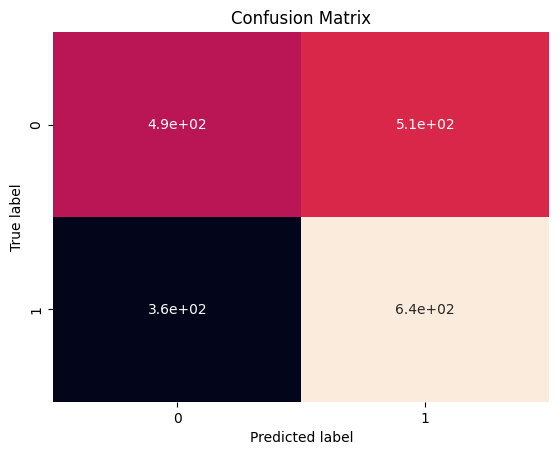

              precision    recall  f1-score   support

           0       0.58      0.49      0.53      1000
           1       0.56      0.64      0.60      1000

    accuracy                           0.56      2000
   macro avg       0.57      0.56      0.56      2000
weighted avg       0.57      0.56      0.56      2000

__________ec__________
Accuracy 0.614
Precision: 0.740000
Recall: 0.591054
F1 score: 0.657194


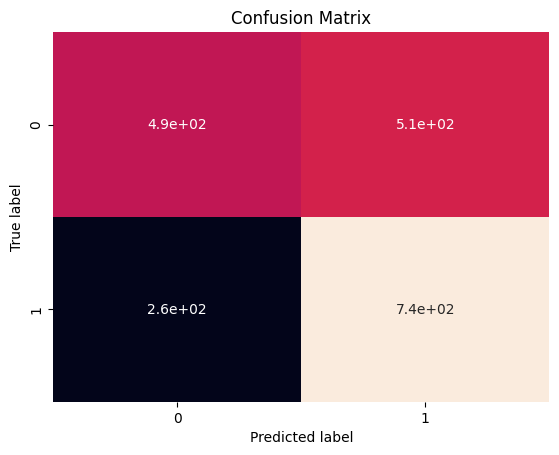

              precision    recall  f1-score   support

           0       0.65      0.49      0.56      1000
           1       0.59      0.74      0.66      1000

    accuracy                           0.61      2000
   macro avg       0.62      0.61      0.61      2000
weighted avg       0.62      0.61      0.61      2000

__________vqvae__________
Accuracy 0.489
Precision: 0.490000
Recall: 0.489022
F1 score: 0.489510


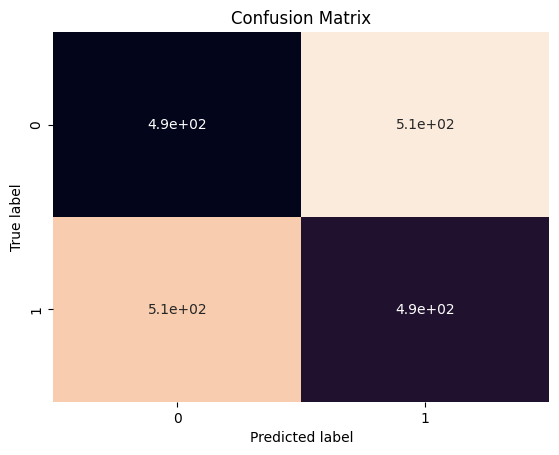

              precision    recall  f1-score   support

           0       0.49      0.49      0.49      1000
           1       0.49      0.49      0.49      1000

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000

__________ 50_freeze __________
__________gen__________
Accuracy 0.5745
Precision: 0.633000
Recall: 0.566697
F1 score: 0.598016


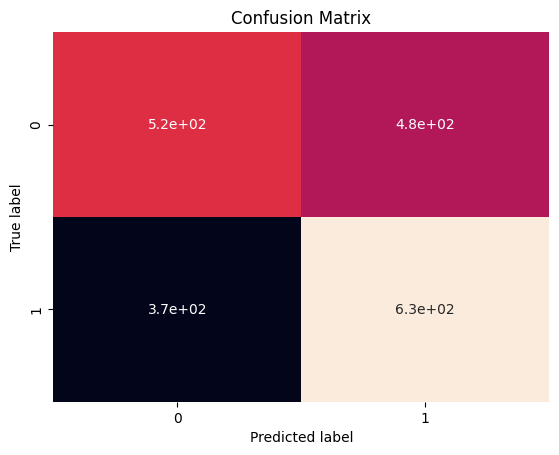

              precision    recall  f1-score   support

           0       0.58      0.52      0.55      1000
           1       0.57      0.63      0.60      1000

    accuracy                           0.57      2000
   macro avg       0.58      0.57      0.57      2000
weighted avg       0.58      0.57      0.57      2000

__________ec__________
Accuracy 0.649
Precision: 0.782000
Recall: 0.617694
F1 score: 0.690203


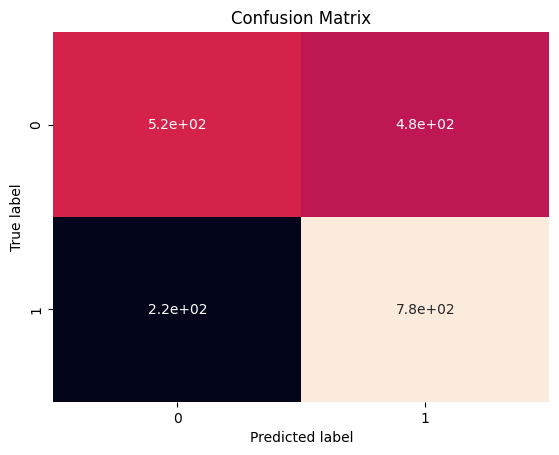

              precision    recall  f1-score   support

           0       0.70      0.52      0.60      1000
           1       0.62      0.78      0.69      1000

    accuracy                           0.65      2000
   macro avg       0.66      0.65      0.64      2000
weighted avg       0.66      0.65      0.64      2000

__________vqvae__________
Accuracy 0.4985
Precision: 0.481000
Recall: 0.498446
F1 score: 0.489567


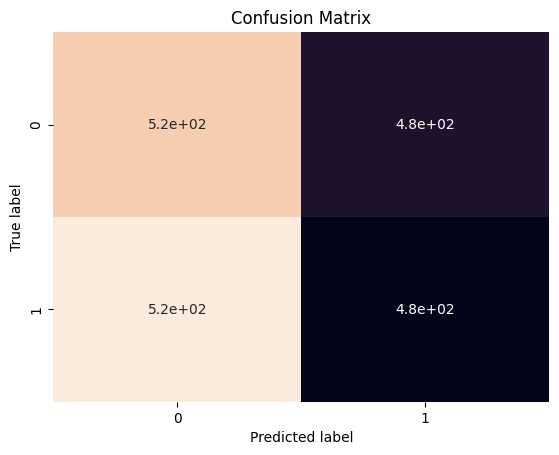

              precision    recall  f1-score   support

           0       0.50      0.52      0.51      1000
           1       0.50      0.48      0.49      1000

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



In [38]:
for model_name in model_softmax.keys():
  print("_"*10, model_name, "_"*10)

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 8)
    y_result = model_svm[model_name].predict(Xtest)

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

    cm8 = confusion_matrix(labels, y_result)
    sns.heatmap(cm8, annot=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(labels, y_result))